# Cardiothoracic Abnormality Assessment 
![](images/embc_heart_tutorial_fig.png)

In this tutorial, we demonstrate how to use `PyKale` to pretrain, fine-tune, evaluate, and interpret deep learning models on two low-cost, non-invasive modalities: **Chest X-ray (CXR)** and **12-lead Electrocardiogram (ECG)**, for assessing **cardiothoracic abnormalities**.

**Estimated runtime:** Completing the steps in this tutorial will take approximately 10 minutes.

We will use a multimodal dataset derived from MIMIC-CXR and MIMIC-IV-ECG, which contains approximately 50K paired CXR and ECG samples. In this tutorial, we pretrain a multimodal **CardioVAE** model using \~49K CXR-ECG pairs via a tri-stream pretraining method. We then fine-tune this pretrained CardioVAE model on a smaller subset (\~1K paired samples) with binary labels: **Healthy** and **Cardiothoracic Abnormality**. Lastly, we demonstrate how to interpret the trained CardioVAE model on both the CXR and ECG modalities.

This notebook is based on the work of [Suvon et al. (MICCAI 2024)](https://link.springer.com/chapter/10.1007/978-3-031-72378-0_28), which introduced a tri-stream pretraining strategy using a **Multimodal Variational Autoencoder (VAE)** to learn both modality-shared and modality-specific representations for assessing **Pulmonary Arterial Wedge Pressure (PAWP)**—a critical indicator of cardiac hemodynamics. The resulting model, **CardioVAE**, is implemented in the [`PyKale`](https://github.com/pykale/pykale) library. Here, we provide a concise example of how to use this model through `PyKale`'s APIs—from pretraining and fine-tuning to model interpretation.

## Step 0: Environment Preparation

### Package installation

The main packages required (excluding `PyKale`) for this tutorial are:

- **wfdb**: A toolkit for reading, writing, and processing physiological signal data, especially useful for ECG waveform analysis.

- **yacs**: A lightweight configuration management library that helps organize experimental settings in a structured, readable format.

- **pytorch-lightning**: A high-level framework built on PyTorch that simplifies training workflows, making code cleaner and easier to scale.

- **tabulate**: Used to print tabular data in a readable format, helpful for summarizing results or configuration parameters.


**Additional Notes for Colab**
Some non-critical dependencies (e.g., `torch-geometric`) may face version conflicts when installing `pykale` on Colab. These are handled manually in the installation step below. An automatic crash and reset have also been added, as the session needs to be restarted after installing these dependencies. **Do not run this block again if you have already run it once.**

In addition, when using Google Colab, please select the **T4 GPU** hardware accelerator to ensure the tutorial runs smoothly. To do this, click the **"Runtime"** option in the top-left menu, then select **"Change runtime type"** and choose **T4 GPU** as the hardware accelerator.

**Estimated runtime:** 4 minutes

In [ ]:
import os

!pip uninstall --quiet -y torch torchvision torchaudio torchdata

!pip install --quiet torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

!pip install --quiet --user \
    git+https://github.com/pykale/pykale@main \
    yacs==0.1.8 wfdb pytorch-lightning tabulate captum neurokit2\
    && echo "pykale,yacs and wfdb installed successfully ✅" \
    || echo "Failed to install pykale,yacs and wfdb ❌"

# This code crashes the Colab runtime, triggering an automatic reset.
os.kill(os.getpid(), 9)

### Setup

As a starting point, we will mount Google Drive in Colab so that the data can be accessed directly. You might be prompted to grant permission to access your Google account—please proceed with the authorisation when asked.

Next, we will install the required packages and load a set of helper functions to support the tutorial workflow. To keep the output clean and focused on interpretation, we also suppress unnecessary warnings.

**Estimated runtime:** 25 seconds

In [ ]:
# Connect with your google drive for data and model loading
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
import os
import site
import sys
import warnings
import logging


# Disable warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

# Suppress PyTorch Lightning logs
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.ERROR)


if "google.colab" in str(get_ipython()):
    sys.path.insert(0, site.getusersitepackages())
    !git clone --single-branch -b main https://github.com/pykale/mmai-tutorials
    %cp -r /content/mmai-tutorials/tutorials/cardiac-hemodynamics-assessment/* /content/

    %rm -r /content/mmai-tutorials

### Configuration

To maintain a clean and modular notebook design, **CardioVAE** uses dedicated configuration files for both pre-training and fine-tuning. This setup ensures a clear separation between code and experimental settings, enhancing reproducibility and flexibility across different tasks and datasets.

Configuration parameters can be overridden using external YAML files (e.g., `experiments/pretraining_base.yml`, `experiments/finetune_base.yml`).

#### Pre-training Configuration

Default settings for the pre-training stage are defined in `config_pretrain.py`. These include data paths, model architecture, and optimizer parameters.
This modular structure allows easy experiment tracking and customisation by simply editing the associated `.yml` file.

In [ ]:
from config_pretrain import get_cfg_defaults

cfg_PT = get_cfg_defaults()
cfg_PT.merge_from_file("configs/pretraining_base.yml")

# ------ Hyperparameters to play with -----
cfg_PT.MODEL.LATENT_DIM = 128
cfg_PT.TRAIN.EPOCHS = 1
cfg_PT.TRAIN.LAMBDA_IMAGE = 1
cfg_PT.TRAIN.LAMBDA_SIGNAL = 10
# User can change this to try different batch size.
cfg_PT.DATA.BATCH_SIZE = 128

print(cfg_PT)


#### Fine-tuning Configuration

Fine-tuning parameters are managed in `config_finetune.py`. These include learning rate, loss weights, number of epochs, model checkpoint paths, and other task-specific options.
External YAML files like `experiments/finetune_base.yml` enable flexible adjustments for different downstream tasks or datasets.


In [ ]:
from config_finetune import get_cfg_defaults

cfg_FT = get_cfg_defaults()
cfg_FT.merge_from_file("configs/finetune_base.yml")

# ------ Hyperparameters to play with -----
cfg_FT.FT.EPOCHS = 10
cfg_FT.FT.HIDDEN_DIM = 128
# User can change this to try different batch size.
cfg_FT.DATA.BATCH_SIZE = 32

print(cfg_FT)

## Step 1: Data Loading and Preparation

This tutorial uses separate data pipelines for **pre-training** and **fine-tuning**, both based on paired chest X-ray (CXR) and ECG signal features. Each stage follows standard preprocessing steps—such as resizing, normalization, interpolation, and tensor conversion—tailored for resource-constrained environments like **Google Colab**.

PyKale API for Data preparation:

- `kale.loaddata.signal_access.load_ecg_from_folder` provides a convenient function for loading ECG waveform data stored in a directory structure. It supports automatic parsing and conversion of ECG signal files into PyTorch tensors, with options for standard preprocessing such as normalisation, resize, interpolation, and resampling. This enables streamlined integration with deep learning pipelines.

- `kale.loaddata.image_access.load_images_from_dir` offers an easy-to-use utility for loading image datasets from directory hierarchies. It supports standard image formats and returns PyTorch tensors, performing essential preprocessing steps such as resizing and normalisation. This function is suitable for image classification, computer vision, and multimodal learning tasks.

- `kale.loaddata.signal_image_access.SignalImageDataset` defines a unified dataset class designed for paired signal (e.g., ECG) and image (e.g., CXR) modalities. It facilitates synchronized access to multi-source data, providing ready-to-use PyTorch datasets that can be directly utilised for multimodal training, evaluation, and downstream applications.

**Note:** Please create a shortcut to the following Google Drive folder in your **MyDrive**.  
To create a shortcut:  
(i) Click the link to open the Google Drive folder.  
(ii) Click the folder name at the top to reveal a **drop-down menu**.  
(iii) From the drop-down menu, select **Organise > Add shortcut**.  
(iv) A dialog box titled *"Add shortcut to 'EMBC_workshop_data'"* will appear — click the **"All locations"** tab, then select **"My Drive"**.  
(v) A shortcut to **EMBC_workshop_data** should now be visible at [https://drive.google.com/drive/my-drive](https://drive.google.com/drive/my-drive).

[Google Drive Link](https://drive.google.com/drive/folders/1N7-fMWsdK-tuB76SdC-GF1njYYGx0Z-i?usp=sharing)

There's no need to download the data manually. After mounting your Google Drive in the setup section, you will be able to directly access all datasets and pretrained models.

### Pre-training Data Loading

To accommodate the resource constraints of platforms like **Google Colab**, this tutorial uses a lightweight version of the dataset consisting of the **first 1,000 preprocessed samples** from the full 50K paired CXR and ECG dataset. This significantly reduces runtime and memory requirements, allowing for rapid experimentation without the overhead of full-scale data loading and transformation.

The complete preprocessing pipeline, implemented using the PyKale API, is provided for reference. Additionally, CSV files containing subject IDs for the full dataset are provided. Users interested in training on the complete 50K dataset can leverage the **PyKale API**, which supports direct loading of raw CXR and ECG features with integrated preprocessing.

**Note:**  
- For ease of use in Colab, the full data loading functionality is **commented out by default**. It can be re-enabled for local or high-resource environments. To load the full 50K paired CXR-ECG data, you need to download the [MIMIC-CXR](https://physionet.org/content/mimic-cxr/2.1.0/) and [MIMIC-IV-ECG](https://physionet.org/content/mimic-iv-ecg/1.0/) datasets, then **uncomment** the optional code cell and run it. 

- To access the required files for dataloading, ensure that the shared folder **`EMBC_workshop_data`** is added as a **shortcut to your Google Drive (under “My Drive”)**.

**Estimated runtime:** 12 seconds


In [ ]:
# (OPTIONAL)
# from kale.loaddata.signal_access import load_ecg_from_folder
# from kale.loaddata.image_access import load_images_from_dir

# ecg_tensor = load_ecg_from_folder("/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/", "mimic_ecg_50K.csv")
# cxr_tensor = load_images_from_dir("/physionet.org/files/mimic-cxr-jpg/2.0.0/", "mimic_cxr_50K.csv")

# train_dataset_PT, val_dataset_PT = SignalImageDataset.prepare_data_loaders( ecg_tensor, cxr_tensor)

In [ ]:
import torch
from kale.loaddata.signal_image_access import SignalImageDataset
from kale.utils.seed import set_seed
import random
import numpy as np
import torch

set_seed(cfg_PT.TRAIN.SEED)

ecg_tensor_PT = torch.load(cfg_PT.DATA.ECG_PATH, map_location=cfg_PT.TRAIN.DATA_DEVICE)
cxr_tensor_PT = torch.load(cfg_PT.DATA.CXR_PATH, map_location=cfg_PT.TRAIN.DATA_DEVICE)

train_dataset_PT, val_dataset_PT = SignalImageDataset.prepare_data_loaders(
    ecg_tensor_PT, cxr_tensor_PT
)

### Fine-tuning Data Loading

For the fine-tuning stage, we use the **last 1,000 paired CXR and ECG samples** from the full 50K dataset derived from **MIMIC-CXR** and **MIMIC-IV-ECG**. Corresponding disease labels are obtained from MIMIC-CXR, which includes 12 cardiothoracic abnormality classes along with a "No Finding" label representing healthy cases.

To formulate a binary classification task, all abnormality classes are grouped into a single **Cardiothoracic Abnormality** category, while the "No Finding" label is treated as **Healthy**. The resulting label mapping is as follows:

- `0` → **Healthy**  
- `1` → **Cardiothoracic Abnormality**

This fine-tuning subset is explicitly selected to ensure no overlap with the samples used during pre-training, thereby simulating a realistic downstream evaluation setting.

Unlike the fine-tuning strategy reported in *Suvon et al., MICCAI 2024*, which relied on a private in-house dataset, this approach is fully reproducible using publicly available data from MIMIC-CXR and MIMIC-IV-ECG.

**Estimated runtime:** 10 seconds

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd

# Set seed for reproducibility
torch.manual_seed(cfg_FT.FT.SEED)

# Load data
ecg_tensor_FT = torch.load(cfg_FT.DATA.ECG_PATH, map_location=cfg_FT.DATA.DATA_DEVICE)
cxr_tensor_FT = torch.load(cfg_FT.DATA.CXR_PATH, map_location=cfg_FT.DATA.DATA_DEVICE)
label_df = pd.read_csv(cfg_FT.DATA.CSV_PATH)
labels = torch.tensor(label_df["label"].values, dtype=torch.long)

# Combine tensors into a single dataset
dataset = TensorDataset(cxr_tensor_FT, ecg_tensor_FT, labels)

# Split into train/val
val_ratio = 0.2
num_samples = len(dataset)
num_val = int(val_ratio * num_samples)
num_train = num_samples - num_val

train_dataset_FT, val_dataset_FT = random_split(
    dataset,
    [num_train, num_val],
    generator=torch.Generator().manual_seed(cfg_FT.FT.SEED),
)

# DataLoaders
train_loader_FT = DataLoader(
    train_dataset_FT,
    batch_size=cfg_FT.DATA.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg_FT.DATA.NUM_WORKERS,
)
val_loader_FT = DataLoader(
    val_dataset_FT,
    batch_size=cfg_FT.DATA.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg_FT.DATA.NUM_WORKERS,
)

## Step 2: Model Definition

We use the **PyKale** library to implement a modular multimodal variational autoencoder (VAE) for learning joint representations from **ECG** and **CXR** data. The architecture includes modality-specific encoders and decoders, a PoE-based fusion mechanism, and task-specific heads for reconstruction and classification.

### Embed

The embedding module is composed of independent encoders for each modality and a fusion mechanism to obtain a shared latent representation.

#### Signal Encoder  
The ECG signal pathway uses `SignalVAEEncoder` from `kale.embed.signal_cnn`.  
This encoder captures high-level temporal features from preprocessed ECG waveforms and maps them to a latent space suitable for downstream fusion and representation learning.

#### Image Encoder  
The image pathway uses `ImageVAEEncoder` from `kale.embed.image_cnn`.  
This encoder captures high-level spatial features from preprocessed CXR's and maps them to a latent space suitable for downstream fusion and representation learning.

#### ️ Feature Fusion  
Encoded modality-specific features are combined using a **Product-of-Experts (PoE)** approach, implemented in `kale.embed.feature_fusion`.  
The PoE fusion computes a joint posterior over the latent space by aggregating information from each modality, enabling coherent multimodal representation.

---

### Predict

#### Reconstruction (Pre-training)  
During pre-training, the model reconstructs both modalities using decoders from the shared latent representation:

- `ImageVAEDecoder` from `kale.embed.vae_decoder` for CXR reconstruction  
- `SignalVAEDecoder` from `kale.embed.signal_cnn_vae` for ECG waveform reconstruction  

The model is trained to minimise the **Evidence Lower Bound (ELBO)**, encouraging informative and disentangled latent representations.

#### Classification (Fine-tuning)  
For downstream classification tasks, we reuse the pretrained encoders as feature extractors.  
The `SignalImageFineTuningClassifier` from [`kale.pipeline.finetune`](https://github.com/pykale/pykale/blob/main/kale/pipeline/finetune.py) adds a lightweight classification head on top of the shared latent space for supervised learning.  
This setup is optimised for clinical prediction tasks, such as binary or multi-label disease classification.


## Step 3: Model Training

### Multimodal Pretraining

We pretraind a CardioVAE model using the `SignalImageVAE` class from **PyKale** to jointly model paired CXR and ECG data. The goal is to learn **shared and modality-specific representations** in an **unsupervised** manner via reconstruction.

We instantiate `SignalImageVAE` from [`kale.embed.multimodal_encoder`](https://github.com/pykale/pykale/blob/main/kale/embed/multimodal_encoder.py), which includes:

- A **signal encoder-decoder** built on `SignalVAEEncoder` for ECG waveforms
- An **image encoder-decoder** built on `ImageVAEEncoder` for CXR images
- A **Product-of-Experts (PoE)** fusion module for combining modality-specific latent vectors into a shared latent representation

To pretrain, we use `SignalImageTriStreamVAETrainer` from [`kale.pipeline.multimodal_trainer`](https://github.com/pykale/pykale/blob/main/kale/pipeline/multimodal_trainer.py) to:

- Perform **joint and single-modality reconstructions**
- Optimise the **ELBO loss**, balancing image and signal modalities
- Manage logging, and reconstruction-based validation

**Estimated runtime:** 2 minutes with 1 epoch

In [ ]:
import pytorch_lightning as pl
from kale.pipeline.multimodal_trainer import SignalImageTriStreamVAETrainer
from kale.embed.multimodal_encoder import SignalImageVAE

model = SignalImageVAE(
    image_input_channels=cfg_PT.MODEL.INPUT_DIM_CXR,
    signal_input_dim=cfg_PT.MODEL.INPUT_DIM_ECG,
    latent_dim=cfg_PT.MODEL.LATENT_DIM,
)

# PyKale trainer instance (all from config)
pl_trainer = SignalImageTriStreamVAETrainer(
    model=model,
    train_dataset=train_dataset_PT,
    val_dataset=val_dataset_PT,
    batch_size=cfg_PT.DATA.BATCH_SIZE,
    num_workers=cfg_PT.DATA.NUM_WORKERS,
    lambda_image=cfg_PT.TRAIN.LAMBDA_IMAGE,
    lambda_signal=cfg_PT.TRAIN.LAMBDA_SIGNAL,
    lr=cfg_PT.TRAIN.LR,
    annealing_epochs=cfg_PT.TRAIN.EPOCHS,
    scale_factor=cfg_PT.TRAIN.SCALE_FACTOR,
)

trainer = pl.Trainer(
    max_epochs=cfg_PT.TRAIN.EPOCHS,
    accelerator=cfg_PT.TRAIN.ACCELERATOR,
    devices=cfg_PT.TRAIN.DEVICES,
    log_every_n_steps=10,
)

trainer.fit(pl_trainer)

# Save model state dict
torch.save(model.state_dict(), cfg_PT.TRAIN.SAVE_PATH)
print(f"Saved model state dictionary to '{cfg_PT.TRAIN.SAVE_PATH}'")

### Multimodal Fine-tuning

For downstream classification, we fine-tune a shallow classifier on top of a **pretrained CardioVAE encoder**. The encoder is loaded from `SignalImageVAE`, pretrained with reconstruction loss, and used as a fixed or partially trainable **feature extractor**.

We use `SignalImageFineTuningClassifier` from [`kale.pipeline.finetune`](https://github.com/pykale/pykale/blob/main/kale/pipeline/finetune.py), which wraps:

- A **pretrained encoder** from `SignalImageVAE`  
- A **classification head** (single or multi-layer MLP)  
- A **training step** that supports standard supervised learning with cross-entropy loss

**Estimated runtime:** 2 minute with 10 epoch


In [ ]:
import torch
import pytorch_lightning as pl
from kale.embed.multimodal_encoder import SignalImageVAE
from kale.pipeline.multimodal_trainer import SignalImageFineTuningTrainer
from kale.utils.remap_model_parameters import remap_state_dict_keys

# Load and remap checkpoint
checkpoint = torch.load(cfg_FT.FT.CKPT_PATH, map_location=cfg_FT.FT.DEVICE)
checkpoint = remap_state_dict_keys(checkpoint)

pretrained_mvae = SignalImageVAE(
    image_input_channels=cfg_FT.MODEL.INPUT_IMAGE_CHANNELS,
    signal_input_dim=cfg_FT.MODEL.INPUT_DIM_ECG,
    latent_dim=cfg_FT.MODEL.LATENT_DIM,
)
pretrained_mvae.load_state_dict(checkpoint, strict=False)
pretrained_mvae.to(cfg_FT.FT.DEVICE)
pretrained_mvae.eval()

model_pl = SignalImageFineTuningTrainer(
    pretrained_model=pretrained_mvae,
    num_classes=cfg_FT.FT.NUM_CLASSES,
    lr=cfg_FT.FT.LR,
    hidden_dim=cfg_FT.FT.HIDDEN_DIM,
)

trainer = pl.Trainer(
    max_epochs=cfg_FT.FT.EPOCHS,
    accelerator=cfg_FT.FT.ACCELERATOR,
    devices=cfg_FT.FT.DEVICES,
    log_every_n_steps=10,
    enable_checkpointing=False,
    logger=False,
)

trainer.fit(model_pl, train_dataloaders=train_loader_FT, val_dataloaders=val_loader_FT)

## Step 4: Evaluation

After training, we extract key validation metrics using PyTorch Lightning's built-in `callback_metrics`. These metrics provide a quantitative summary of model performance on the validation set.

We report the following:

- **Accuracy**: Proportion of correct predictions  
- **AUROC**: Area under the Receiver Operating Characteristic curve, measuring ranking quality  
- **MCC**: Matthews Correlation Coefficient, a balanced metric even for imbalanced classes

The metrics are printed in a tabulated format using the `tabulate` library for clear presentation.

In [ ]:
from tabulate import tabulate

# Get validation metrics
val_metrics = trainer.callback_metrics
acc = val_metrics["val_acc"].item() if "val_acc" in val_metrics else float("nan")
auc = val_metrics["val_auroc"].item() if "val_auroc" in val_metrics else float("nan")
mcc = val_metrics["val_mcc"].item() if "val_mcc" in val_metrics else float("nan")

# Print metrics
table_data = [
    ["Accuracy", f"{acc:.3f}"],
    ["AUROC", f"{auc:.3f}"],
    ["MCC", f"{mcc:.3f}"],
]
print("\n=== Validation Summary ===")
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))


=== Validation Summary ===
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ Accuracy │   0.663 │
├──────────┼─────────┤
│ AUROC    │   0.726 │
├──────────┼─────────┤
│ MCC      │   0.326 │
╘══════════╧═════════╛


## Step 5: Interpretation

We interpret the fine-tuned model using the multimodal_signal_image_attribution interpretation method from PyKale, which builds on Captum's Integrated Gradients to generate visual explanations for both CXR and ECG inputs.
This method helps identify which regions in each modality, such as specific waveform segments in ECG and spatial regions in CXR, contributed most to the model’s prediction. This improves both transparency and clinical interpretability.

**Estimated runtime:** 10 seconds


In [ ]:
from kale.interpret.signal_image_attribution import multimodal_signal_image_attribution
import matplotlib.pyplot as plt
import numpy as np

# User can change this to try different ECG and CXR interpretation configaration to play with
cfg_FT.INTERPRET.ECG_THRESHOLD = 0.75
cfg_FT.INTERPRET.SAMPLE_IDX = 3
cfg_FT.INTERPRET.ZOOM_RANGE = [3.5, 4]
cfg_FT.INTERPRET.CXR_THRESHOLD = 0.75


sample_idx = cfg_FT.INTERPRET.SAMPLE_IDX
zoom_range = tuple(cfg_FT.INTERPRET.ZOOM_RANGE)
ecg_threshold = cfg_FT.INTERPRET.ECG_THRESHOLD
cxr_threshold = cfg_FT.INTERPRET.CXR_THRESHOLD
lead_number = cfg_FT.MODEL.NUM_LEADS
sampling_rate = cfg_FT.INTERPRET.SAMPLING_RATE


# Run interpretation
result = multimodal_signal_image_attribution(
    last_fold_model=model_pl,
    last_val_loader=val_loader_FT,
    sample_idx=sample_idx,
    signal_threshold=ecg_threshold,
    image_threshold=cxr_threshold,
    zoom_range=zoom_range,
)

**Full ECG View:** Displays attribution across the full 12-lead ECG signal. A percentile-based threshold (e.g., top 25%) is applied to highlight segments with the highest contribution.

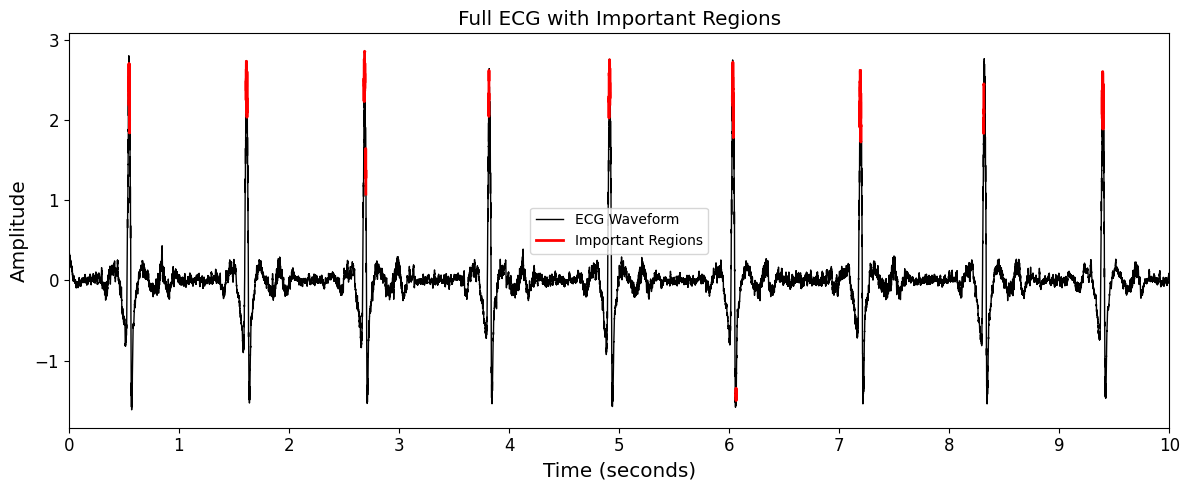

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Plot the full ECG waveform
ax.plot(
    result["full_time"],
    result["signal_waveform_np"][: result["full_length"]],
    color="black",
    linewidth=1,
    label="ECG Waveform",
)

for idx in result["important_indices_full"]:
    stretch_start = max(0, idx - 6)
    stretch_end = min(result["full_length"], idx + 6 + 1)
    ax.plot(
        result["full_time"][stretch_start:stretch_end],
        result["signal_waveform_np"][stretch_start:stretch_end],
        color="red",
        linewidth=2,
    )

ax.set_xlabel("Time (seconds)", fontsize="x-large")
ax.set_ylabel("Amplitude", fontsize="x-large")
ax.set_title("Full ECG with Important Regions", fontsize="x-large")
ax.set_xticks(np.linspace(0, 10, 11))
ax.set_xlim([0, 10])
ax.tick_params(axis="x", labelsize="large")
ax.tick_params(axis="y", labelsize="large")
ax.legend(["ECG Waveform", "Important Regions"], fontsize="medium")

plt.tight_layout()
plt.show()

**Zoomed-In ECG Segment:** Focuses on a specific time window (e.g., 3 to 4 seconds) for fine-grained inspection of high-attribution waveform regions.

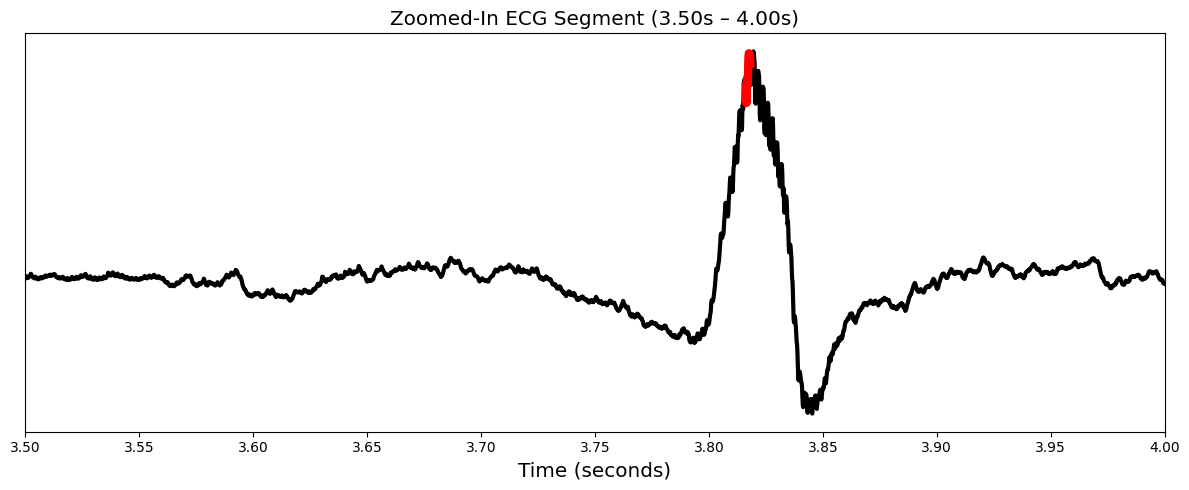

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Plot zoomed-in ECG segment
ax.plot(
    result["zoom_time"],
    result["segment_signal_waveform"],
    color="black",
    linewidth=3,
    label="ECG Waveform",
)


for idx in result["important_indices_zoom"]:
    stretch_start = max(0, idx - 6)
    stretch_end = min(len(result["segment_signal_waveform"]), idx + 6 + 1)
    ax.plot(
        result["zoom_time"][stretch_start:stretch_end],
        result["segment_signal_waveform"][stretch_start:stretch_end],
        color="red",
        linewidth=6,
    )


ax.set_xticks(np.linspace(result["zoom_start_sec"], result["zoom_end_sec"], 11))
ax.set_xlim([result["zoom_start_sec"], result["zoom_end_sec"]])
ax.set_yticks([])
ax.set_xlabel("Time (seconds)", fontsize="x-large")
ax.set_ylabel("")
ax.set_title(
    f'Zoomed-In ECG Segment ({result["zoom_start_sec"]:.2f}s – {result["zoom_end_sec"]:.2f}s)',
    fontsize="x-large",
)

plt.tight_layout()
plt.show()

**CXR Attribution Map:** Shows a heatmap over the input CXR image, with highlighted areas corresponding to regions above a configurable percentile threshold (e.g., top 25%). This helps reveal where the model focused attention in the spatial domain.

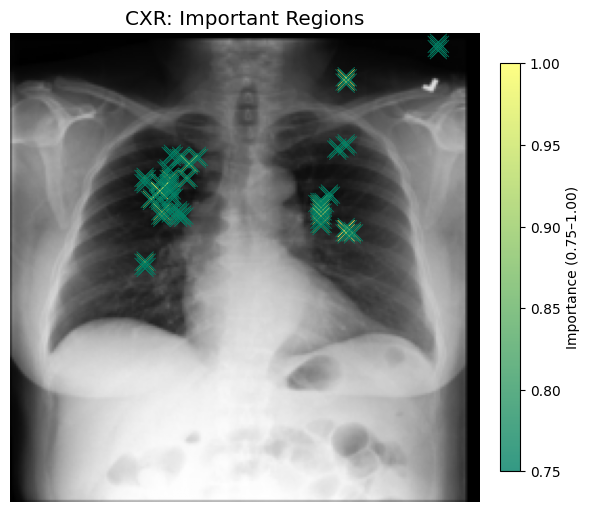

In [ ]:
x_pts = result["x_pts"]
y_pts = result["y_pts"]
importance_pts = result["importance_pts"]
cxr_thresh = result["image_threshold"]

fig, ax = plt.subplots(figsize=(6, 6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Show base CXR image
ax.imshow(result["image_np"], cmap="gray", alpha=1)

# Overlay attribution points
sc = ax.scatter(
    x_pts,
    y_pts,
    c=importance_pts,
    cmap="summer",
    marker="x",
    s=150,
    vmin=cxr_thresh,
    vmax=1.0,
    alpha=0.8,
    linewidths=0.7,
    edgecolor="black",
)

# Add colorbar for importance
cbar = plt.colorbar(sc, ax=ax, fraction=0.04, pad=0.04)
cbar.set_label(f"Importance ({cxr_thresh:.2f}–1.00)")

# Final formatting
ax.axis("off")
ax.set_title("CXR: Important Regions", fontsize="x-large")

plt.tight_layout()
plt.show()